# Analyzing `nakeds`

## 1. Generate Nakeds
### Provide inputs

In [1]:
# * NAKED FUNCTION INPUTS
MARKET = 'NSE'
SYMBOL = 'RBLBANK'
EARLIEST = False
RECALC_UNDS = True
SAVE = False

RUN_ON_PAPER = True

In [2]:
# * IMPORTS
import IPython as ipy
import nest_asyncio
import pathlib

import pandas as pd
import numpy as np
from nakeds import get_nakeds
import datetime
from ib_insync import IB
from engine import Vars

import asyncio

# * SETUP

# . current working directory path
cwd = pathlib.Path.cwd()

# . get the host, port, cid
ibp = Vars(MARKET.upper())  # IB Parameters from var.yml
HOST, CID = ibp.HOST, ibp.CID
if RUN_ON_PAPER:
    PORT = ibp.PAPER
else:
    PORT = ibp.PORT

In [3]:
# Specific to Jupyter. Will be ignored in IDE / command-lines

if ipy.get_ipython().__class__.__name__ == 'ZMQInteractiveShell':

    from ib_insync import util
    nest_asyncio.apply()
    util.startLoop()
    pd.options.display.max_columns = None
    pd.options.display.float_format = '{:,.2f}'.format # set float precision with comma
    
    THIS_FOLDER = '' # Dummy for jupyter notebook's current folder
    BAR_FORMAT = "{l_bar}{bar:-20}{r_bar}"

In [4]:
# Get the pickle files
from os import listdir

cwd = pathlib.Path.cwd() # working directory from where python was initiated
DATAPATH = cwd.joinpath('data', MARKET.lower()) # path to store data files

fs = listdir(DATAPATH)

files = [f for f in fs if f[-4:] == '.pkl']
for f in files:
    exec(f"{f.split('.')[0]} = pd.read_pickle(DATAPATH.joinpath(f))")
np.sort(np.array(files))

array(['df_chains.pkl', 'df_nakeds.pkl', 'df_ohlcs.pkl',
       'df_opt_prices.pkl', 'df_opts.pkl', 'df_symlots.pkl',
       'df_unds.pkl', 'dfrq.pkl', 'qopt_rejects.pkl', 'qopts.pkl'],
      dtype='<U17')

### Set the connection

In [5]:
# Get the host, port, cid
from engine import *
from support import *

ibp = Vars(MARKET.upper())  # IB Parameters from var.yml
HOST, PORT, CID = ibp.HOST, ibp.PORT, ibp.CID

# * SET THE CONNECTION
def connect(HOST, PORT, CID):
    try:
        if ib.isConnected():
            print(f"IB is already connected to host: {ib.client.host}, port:{ib.client.port}, clientId: {ib.client.clientId}")
        else:
            ib = IB().connect(HOST, PORT, CID)
            print(f"IB is set to host: {ib.client.host}, port:{ib.client.port}, clientId: {ib.client.clientId}")

    except NameError:
        try:
            ib = IB().connect(HOST, PORT, CID)
            print(f"IB connection status is now: {ib.isConnected()} at {ib.client.host}, port:{ib.client.port}, clientId: {ib.client.clientId}")
        
        except Exception:
            print(f"IB connection failed for {HOST}, port:{PORT}, clientId: {CID}")
            ib = None
    
    return ib

### Get the nakeds and ohlcs

In [6]:
df_tgt = df_nakeds[df_nakeds.symbol == SYMBOL]

In [7]:
drop_cols = ['contract', 'secType', 'comm', 
                    'lot', 'close', 'last', 'intrinsic']

df_print = df_tgt.drop(drop_cols, 1)
df_print

,conId,symbol,dte,right,strike,expiry,und_iv,undPrice,und_sd,fallrise,fr_sd,margin,bid,ask,iv,timevalue,price,expPrice,rom,expRom,sdMult,prop,remq,qty
1,459089605,RBLBANK,37,C,315.00,20210128,0.66,206.55,2.49,573.35,8.42,"114,367.39",-1.00,-1.00,0.66,5.55,5.55,5.55,1.39,1.39,2.49,0.99,2,"2,900.00"
4,459328560,RBLBANK,37,C,320.00,20210128,0.66,206.55,2.60,573.35,8.42,"109,763.63",-1.00,-1.00,0.66,4.95,4.95,4.95,1.29,1.29,2.60,0.99,2,"2,900.00"
7,459328570,RBLBANK,37,C,325.00,20210128,0.66,206.55,2.72,573.35,8.42,"105,377.39",-1.00,-1.00,0.66,4.45,4.45,4.45,1.21,1.21,2.72,0.99,2,"2,900.00"
17,458881940,RBLBANK,37,C,310.00,20210128,0.66,206.55,2.37,573.35,8.42,"119,152.39",-1.00,-1.00,0.66,4.00,4.00,4.00,0.96,0.96,2.37,0.98,2,"2,900.00"
36,459089597,RBLBANK,9,C,315.00,20201231,0.66,206.55,5.05,414.35,9.67,"81,996.28",-1.00,-1.00,0.66,0.55,0.55,0.55,0.70,0.70,5.05,1.00,2,"2,600.00"
41,459328545,RBLBANK,9,C,320.00,20201231,0.66,206.55,5.28,414.35,9.67,"77,446.28",-1.00,-1.00,0.66,0.45,0.45,0.45,0.60,0.60,5.28,1.00,2,"2,600.00"
52,459328555,RBLBANK,9,C,325.00,20201231,0.66,206.55,5.51,414.35,9.67,"73,123.78",-1.00,-1.00,0.66,0.35,0.35,0.40,0.49,0.55,5.51,1.00,2,"2,600.00"
138,458881935,RBLBANK,9,C,310.00,20201231,0.66,206.55,4.81,414.35,9.67,"86,741.28",-1.00,-1.00,0.66,0.20,0.20,0.45,0.23,0.55,4.81,1.00,2,"2,600.00"
281,447304810,RBLBANK,9,P,80.00,20201231,0.66,206.55,5.89,112.45,4.38,"57,133.78",-1.00,-1.00,0.66,0.05,0.05,0.35,0.08,0.55,5.89,1.00,2,"2,600.00"
296,447304817,RBLBANK,9,P,85.00,20201231,0.66,206.55,5.66,112.45,4.38,"62,821.28",-1.00,-1.00,0.66,0.05,0.05,0.40,0.07,0.55,5.66,1.00,2,"2,600.00"


## 2. Plots
### a) OHLCs of underlying from pickle

In [8]:
und_ohlcs = pd.read_pickle(cwd.joinpath('data', MARKET.lower(), 'df_ohlcs.pkl'))
und_ohlcs = und_ohlcs[und_ohlcs.symbol.isin([SYMBOL])]

(<Figure size 720x432 with 1 Axes>,)

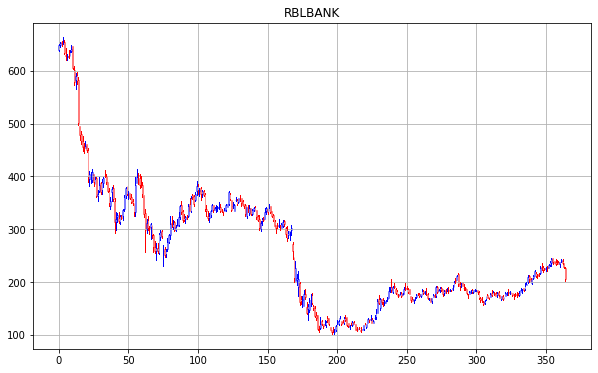

In [9]:
util.barplot(und_ohlcs, title=SYMBOL),

### b) OHLC - options live

#### Set up the contracts

In [10]:
# . underlying contracts
df_unds = pd.read_pickle(cwd.joinpath('data', MARKET.lower(), 'df_unds.pkl'))
und_ct = df_unds[df_unds.symbol == SYMBOL].contract.iloc[0]

# . option contracts

# ... get some with bid and ask
m1 = df_nakeds.bid>0
m2 = df_nakeds.ask>0
m3 = df_nakeds.symbol == SYMBOL

# if bid and ask price are not present (market closed), use last price
if df_nakeds[m1&m2&m3].empty:
    dfo = df_nakeds[m3]
else:
    dfo = df_nakeds[m1&m2&m3]


# ... choose the top one
opt_ct = dfo[dfo.conId == dfo.conId.iloc[0]].contract.iloc[0]

In [11]:
cols = "symbol	dte	right	strike	undPrice	expiry	contract	lot	und_iv	und_sd	fallrise	fr_sd	margin	bid	ask	close	last	iv	sdMult	prop	rom	expRom	price	expPrice	remq	qty".split('	')

In [12]:
dfo[cols].head()

,symbol,dte,right,strike,undPrice,expiry,contract,lot,und_iv,und_sd,fallrise,fr_sd,margin,bid,ask,close,last,iv,sdMult,prop,rom,expRom,price,expPrice,remq,qty
1,RBLBANK,37,C,315.00,206.55,20210128,"Option(conId=459089605, symbol='RBLBANK', last...","2,900.00",0.66,2.49,573.35,8.42,"114,367.39",-1.00,-1.00,5.55,nan,0.66,2.49,0.99,1.39,1.39,5.55,5.55,2,"2,900.00"
4,RBLBANK,37,C,320.00,206.55,20210128,"Option(conId=459328560, symbol='RBLBANK', last...","2,900.00",0.66,2.60,573.35,8.42,"109,763.63",-1.00,-1.00,4.95,nan,0.66,2.60,0.99,1.29,1.29,4.95,4.95,2,"2,900.00"
7,RBLBANK,37,C,325.00,206.55,20210128,"Option(conId=459328570, symbol='RBLBANK', last...","2,900.00",0.66,2.72,573.35,8.42,"105,377.39",-1.00,-1.00,4.45,nan,0.66,2.72,0.99,1.21,1.21,4.45,4.45,2,"2,900.00"
17,RBLBANK,37,C,310.00,206.55,20210128,"Option(conId=458881940, symbol='RBLBANK', last...","2,900.00",0.66,2.37,573.35,8.42,"119,152.39",-1.00,-1.00,4.00,nan,0.66,2.37,0.98,0.96,0.96,4.00,4.00,2,"2,900.00"
36,RBLBANK,9,C,315.00,206.55,20201231,"Option(conId=459089597, symbol='RBLBANK', last...","2,600.00",0.66,5.05,414.35,9.67,"81,996.28",-1.00,-1.00,0.55,nan,0.66,5.05,1.00,0.70,0.70,0.55,0.55,2,"2,600.00"


#### Experiment with OHLC function for options

In [13]:
# .OHLC
async def ohlc(ib: IB,
               c, # contract
               DURATION: int = 365,
               OHLC_DELAY: int = 5) -> pd.DataFrame:

    "Gets OHLC history for stocks / options in UTC date" 

    if isinstance(c, tuple):
        c = c[0]

    if c.secType == 'OPT':
        DUR = "10 D"
        BAR_SIZE = "8 hours"
        WHAT_TO_SHOW = "MIDPOINT"

    else: # for non-options
        DUR = str(DURATION) + " D"
        BAR_SIZE = "1 day"
        WHAT_TO_SHOW = "TRADES"

    ohlc = await ib.reqHistoricalDataAsync(
        contract=c,
        endDateTime=datetime.datetime.now(),
        durationStr=DUR,
        barSizeSetting=BAR_SIZE,
        whatToShow=WHAT_TO_SHOW,
        useRTH=True,
        formatDate=2, # UTC format
    )
    await asyncio.sleep(OHLC_DELAY)
    df = util.df(ohlc)

    # re-cast OHLC for options
    if c.secType == 'OPT':

        # Introduce date without time
        df['dt'] = df['date'].dt.date
        
        # get the grouped values for the option
        g = df.groupby('dt')

        op = g.open.first()
        hi = g.high.max()
        lo = g.low.min()
        cl = g.close.last()
        vol = g.volume.sum()
        avg = g.average.mean()
        bc = g.barCount.sum()        

        df1 = pd.DataFrame({'date': df.dt.unique()})

        df = df1.assign(open=df1['date'].map(op),
                high=df1['date'].map(hi),
                low=df1['date'].map(lo),
                close=df1['date'].map(cl),
                volume=df1['date'].map(vol),
                average=df1['date'].map(avg),
                barCount=df1['date'].map(bc))

        df.insert(0, "localSymbol", c.localSymbol)
        df.insert(1, "strike", c.strike)
        df.insert(2, "right", c.right)
        df.insert(3, "expiry", c.lastTradeDateOrContractMonth)

    df.insert(0, "conId", c.conId)
    df.insert(1, "symbol", c.symbol)
    

    return df

In [15]:
%%time
"""with IB().connect(HOST, PORT, CID )as ib:
    und_ohlcs = ib.run(ohlc(ib, und_ct, 365, 5))"""
    
with IB().connect(HOST, PORT, CID )as ib:
    opt_ohlcs = ib.run(ohlc(ib, opt_ct))

opt_ohlcs

Error 162, reqId 12249: Historical Market Data Service error message:HMDS query returned no data: RBLBANK21JAN315CE@NSE Midpoint, contract: Option(conId=459089605, symbol='RBLBANK', lastTradeDateOrContractMonth='20210128', strike=315.0, right='C', multiplier='1', exchange='NSE', currency='INR', localSymbol='RBLBANK21JAN315CE', tradingClass='RBLBANK')


TypeError: 'NoneType' object is not subscriptable

### Plot the und and option

In [ ]:
util.barplot(und_ohlcs, title=SYMBOL),

In [16]:
util.barplot(opt_ohlcs, title=opt_ct.localSymbol),

NameError: name 'opt_ohlcs' is not defined

In [ ]:
opt_ohlcs.head()

### option ohlcs
* Let us play around with option ohlcs

In [20]:
async def opt_ohlc(ib: IB,
                   c, # contract
                   DURATION: str="2 W",
                   OHLC_DELAY: int = 5,
                   BAR_SIZE: str="8 hours",
                   WHAT_TO_SHOW: str="MIDPOINT") -> pd.DataFrame:

    "Gets option OHLC history in UTC date"
    if c.secType == 'OPT':
        DUR = DURATION
        BAR_SIZE = BAR_SIZE
        WHAT_TO_SHOW = WHAT_TO_SHOW

    else:
        print(f'\n{c} is not an option! It is {c.secType}')
        return None
    
    ohlc = await ib.reqHistoricalDataAsync(
        contract=c,
        endDateTime=datetime.datetime.now(),
        durationStr=DUR,
        barSizeSetting=BAR_SIZE,
        whatToShow=WHAT_TO_SHOW,
        useRTH=False,
        formatDate=2, # UTC format
    )
    await asyncio.sleep(OHLC_DELAY)
    df = util.df(ohlc)
    
    return df

In [34]:
with IB().connect(HOST, PORT, CID) as ib:
    opt_ct1 = ib.qualifyContracts(Option(symbol='SRTRANSFI', lastTradeDateOrContractMonth='20201231', strike=1200.0, right='C', exchange='NSE'))[0]

In [35]:
opt_ct1

Option(conId=455944952, symbol='SRTRANSFI', lastTradeDateOrContractMonth='20201231', strike=1200.0, right='C', multiplier='1', exchange='NSE', currency='INR', localSymbol='SRTRANSFIN20DEC1200CE', tradingClass='SRTRANSFIN')

In [46]:
%%time
with IB().connect(HOST, PORT, CID )as ib:
#     opt_ohlcs1 = ib.run(opt_ohlc(ib, opt_ct1, DURATION='10 D', OHLC_DELAY=5,  BAR_SIZE="1 hour", WHAT_TO_SHOW="MIDPOINT"))
    opt_ohlcs1 = ib.run(ohlc(ib, opt_ct1, DURATION='10 D', OHLC_DELAY=5))

opt_ohlcs1

Wall time: 5.81 s


,conId,symbol,localSymbol,strike,right,expiry,date,open,high,low,close,volume,average,barCount
0,455944952,SRTRANSFI,SRTRANSFIN20DEC1200CE,"1,200.00",C,20201231,2020-12-04,20.02,20.02,8.65,10.72,-2,-1.00,-2
1,455944952,SRTRANSFI,SRTRANSFIN20DEC1200CE,"1,200.00",C,20201231,2020-12-07,11.20,27.48,11.00,19.27,-2,-1.00,-2
2,455944952,SRTRANSFI,SRTRANSFIN20DEC1200CE,"1,200.00",C,20201231,2020-12-08,20.20,22.10,14.80,18.70,-2,-1.00,-2
3,455944952,SRTRANSFI,SRTRANSFIN20DEC1200CE,"1,200.00",C,20201231,2020-12-09,21.75,22.30,16.23,18.07,-2,-1.00,-2
4,455944952,SRTRANSFI,SRTRANSFIN20DEC1200CE,"1,200.00",C,20201231,2020-12-10,16.05,17.48,11.93,15.20,-2,-1.00,-2
5,455944952,SRTRANSFI,SRTRANSFIN20DEC1200CE,"1,200.00",C,20201231,2020-12-11,15.85,20.05,13.25,13.25,-2,-1.00,-2
6,455944952,SRTRANSFI,SRTRANSFIN20DEC1200CE,"1,200.00",C,20201231,2020-12-14,16.50,17.18,13.28,16.88,-2,-1.00,-2
7,455944952,SRTRANSFI,SRTRANSFIN20DEC1200CE,"1,200.00",C,20201231,2020-12-15,16.73,23.90,13.05,21.40,-2,-1.00,-2
8,455944952,SRTRANSFI,SRTRANSFIN20DEC1200CE,"1,200.00",C,20201231,2020-12-16,20.10,23.60,14.88,15.95,-2,-1.00,-2
9,455944952,SRTRANSFI,SRTRANSFIN20DEC1200CE,"1,200.00",C,20201231,2020-12-17,16.68,16.68,11.55,12.28,-1,-1.00,-1


(<Figure size 720x432 with 1 Axes>,)

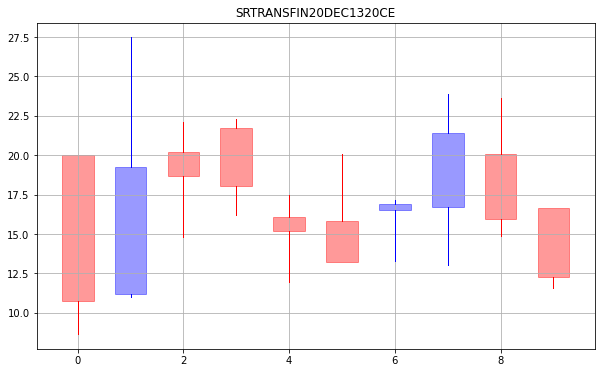

In [47]:
util.barplot(opt_ohlcs1, title=opt_ct.localSymbol),

In [48]:
df_ohlcs

,conId,symbol,date,open,high,low,close,volume,average,barCount
45819,56988999,SRTRANSFI,2019-06-26,"1,123.00","1,126.95","1,087.00","1,099.60",216100,"1,108.13",8277
45820,56988999,SRTRANSFI,2019-06-27,"1,106.50","1,106.50","1,086.15","1,098.65",207018,"1,097.35",6511
45821,56988999,SRTRANSFI,2019-06-28,"1,103.00","1,103.00","1,074.55","1,080.45",240645,"1,082.09",6463
45822,56988999,SRTRANSFI,2019-07-01,"1,084.00","1,092.00","1,050.00","1,054.65",211674,"1,061.81",7270
45823,56988999,SRTRANSFI,2019-07-02,"1,057.65","1,077.75","1,057.65","1,067.75",228472,"1,068.44",7331
...,...,...,...,...,...,...,...,...,...,...
46179,56988999,SRTRANSFI,2020-12-10,"1,053.10","1,062.00","1,025.05","1,049.75",410686,"1,040.27",9758
46180,56988999,SRTRANSFI,2020-12-11,"1,058.45","1,075.00","1,035.00","1,043.25",526355,"1,048.03",12036
46181,56988999,SRTRANSFI,2020-12-14,"1,054.30","1,073.80","1,046.60","1,070.00",466765,"1,061.52",10383
46182,56988999,SRTRANSFI,2020-12-15,"1,071.60","1,101.65","1,054.00","1,092.40",457340,"1,074.41",10244
